# Minimal Inference for Planning with GFE

In [1]:
using LinearAlgebra
using ForneyLab
using Plots

include("factor_nodes/DiscreteObservation.jl")
include("update_rules/DiscreteObservation.jl")
;

# Model

In [2]:
fg = FactorGraph()

A = [0.98 0.02; 
     0.02 0.98]

C = [0.5, 0.5]

D = [0.1, 0.9]

@RV x ~ Categorical(D)
DiscreteObservation(x, A, C)
;

In [3]:
q = PosteriorFactorization(fg)
algo = messagePassingAlgorithm(q, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(code))
;

In [4]:
println(code)

begin

function init()

messages = Array{Message}(undef, 2)

messages[1] = Message(vague(Categorical, (2,)))

return messages

end

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleSPCategoricalOutNP(nothing, Message(Multivariate, PointMass, m=[0.1, 0.9]))
messages[2] = ruleSPDiscreteObservationOutDPP(messages[1], marginals[:x], Message(MatrixVariate, PointMass, m=[0.98 0.02; 0.02 0.98]), Message(Multivariate, PointMass, m=[0.5, 0.5]))

marginals[:x] = messages[1].dist * messages[2].dist

return marginals

end

function freeEnergy(data::Dict, marginals::Dict)

F = 0.0

F += averageEnergy(Categorical, marginals[:x], Distribution(Multivariate, PointMass, m=[0.1, 0.9]))
F += averageEnergy(DiscreteObservation, marginals[:x], Distribution(MatrixVariate, PointMass, m=[0.98 0.02; 0.02 0.98]), Distribution(Multivariate, PointMass, m=[0.5, 0.5]))

F -= differentialEntropy(marginals[:x])

return F

end

end # block


# Results

In [5]:
n_its = 5
G = zeros(n_its)
p_0 = 0.9 # Initial coordinate
p = Vector{Float64}(undef, n_its) # Coordinates

data = Dict()

marginals = Dict{Symbol, ProbabilityDistribution}(
    :x => ProbabilityDistribution(Univariate, Categorical, p=[p_0, 1.0 - p_0]))

G_0 = freeEnergy(data, marginals)
for k=1:n_its
    step!(data, marginals)
    p[k] = marginals[:x].params[:p][1]
    G[k] = freeEnergy(data, marginals)
end
;


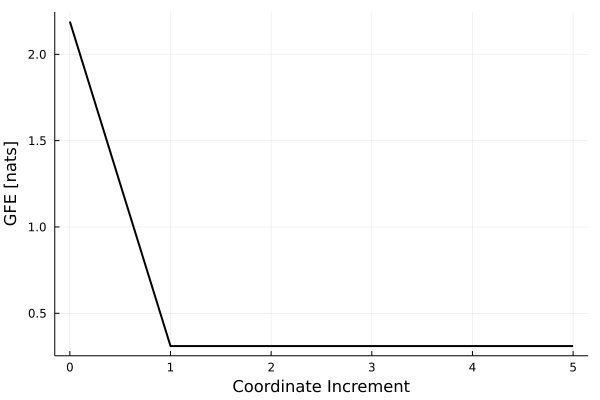

In [6]:
plot(0:n_its, [G_0; G], color=:black, grid=true, linewidth=2, legend=false, xlabel="Coordinate Increment", ylabel="GFE [nats]")

# Landscape

In [7]:
xs = 0.0:0.05:1.0
m = length(xs)
Gs = zeros(m)
for i = 1:m
    data = Dict()
    m_x = Distribution(Univariate, Categorical, p=[xs[i], 1.0 - xs[i]])
    margs = Dict{Symbol, ProbabilityDistribution}(:x => m_x)
    Gs[i] = freeEnergy(data, margs)
end

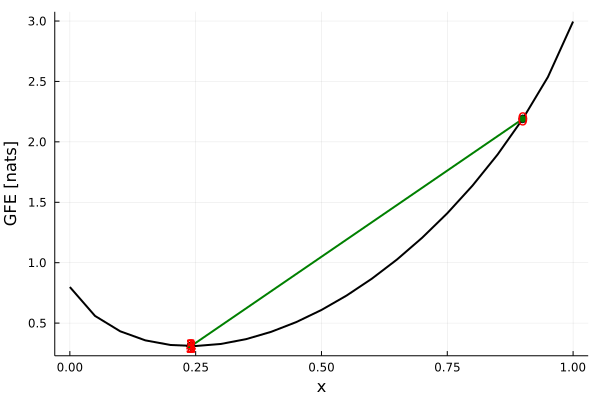

In [8]:
plt = plot(xs,
           Gs,
           dpi=100,
           xlabel="x",
           ylabel="GFE [nats]", color=:black, linewidth=2)

plot!([p_0; p], [G_0; G], color=:green, marker=:o, linewidth=2, legend=false)

for k=1:n_its+1
    ann = ([p_0; p][k], [G_0; G][k], text(k-1, 12, :red, :center))
    annotate!(ann, linecolor=:red)
end

plt